# Left to Right Pixel Graph of Demo Screen

In [1]:
colors_base = {
"00":"c64_black",  
"01":"c64_white",  
"02":"c64_red",    
"03":"c64_cyan",   
"04":"c64_purple", 
"05":"c64_green",  
"06":"c64_blue",   
"07":"c64_yellow", 
"08":"c64_orange", 
"09":"c64_brown",  
"0a":"c64_ltred",  
"0b":"c64_gray1",  
"0c":"c64_lightgray",  
"0d":"c64_ltgreen",
"0e":"c64_ltblue", 
"0f":"c64_gray3",  
}
colors = [v for k,v in colors_base.items()]
    
c64_to_rgb = {
"c64_black": "#000000",     
"c64_white": "#ffffff",     
"c64_red": "#880000",       
"c64_cyan":  "#aaffee",     
"c64_purple": "#cc44cc",    
"c64_green": "#00cc55",     
#"c64_blue":  "#0000aa",     
"c64_blue":  "#0088ff",     
"c64_yellow":  "#eeee77",   
"c64_orange":  "#dd8855",   
"c64_brown": "#664400",     
"c64_ltred": "#ff7777",  
"c64_gray1":  "#333333",    
"c64_ltgreen": "#aaff66",
"c64_ltblue":  "#0088ff",
"c64_lightgrey": "#bbbbbb", 
"c64_lightgray": "#bbbbbb", 
"c64_gray3": "#bbbbbb",                             
}


Run the following command:
```sh
~/Dev/vice-emu-code/vice/src/x64sc -directory ~/Dev/vice-emu-code/vice/data/ -moncommands painttrace.txt bin/psychedelia.prg 
```
Where `painttrace.txt` is:

```
log on
logname "PsychedeliaDemoPaintTrace.txt"
tr exec 0973
command 1 "mem d800 dbff"
```

Read in the ram history.

In [2]:
log_file = "PsychedeliaDemoPaintTrace.txt"
input_file = open(log_file,'r')

ram_history = []
lines = input_file.readlines()
c = 0
for i in range(5, len(lines), 69):
    raw_ram = [l[9:60].split() for l in lines[i:i+64]]
    raw_ram = [int(v,16) & 0x0f for l in raw_ram for v in l]
    color_ram = [raw_ram[v:v+40] for v in range(0, len(raw_ram), 40)][:-2]
    
    raw_ram = [l[9:60].split() for l in lines[i+64:i+66]]
    raw_ram = [int(v,16) for l in raw_ram for v in l]
    settings_ram = [raw_ram[v:v+40] for v in range(0, len(raw_ram), 40)]

    ram_history += [(color_ram,settings_ram)]
    c += 1


Segment per pattern type

In [3]:
flatten = lambda l: [e for sublist in l for e in sublist]

pattern_breaks = []
pp = -1
for i,(h,s) in enumerate(ram_history):
    p = s[-1]
    if p == pp:
        continue
    pattern_breaks += [i]
    pp = p

segments = []
pp = -1
for p in pattern_breaks:
    if len(ram_history[pp+1:p]) > 1:
        segments += [ram_history[pp+1:p]]
    pp = p


In [4]:
segments[3][0][1]

[[0, 11, 1, 28, 2, 10, 7, 9, 1, 7, 0, 7, 3, 14, 6, 2, 4, 10, 0, 0, 7]]

In [9]:
from PIL import Image, ImageColor

bit_array = ([['0' for i in range(8)]] 
            + [['0']+['1' for i in range(6)]+['0'] for j in range(6)] 
            + [['0' for i in range(8)]])

def paintChar(origin, pixels, cv):
    c, r = origin
    x_o, y_o = c*8, r*8
    for y, l in enumerate(bit_array):
        for x,bit in enumerate(l):
            if bit == "0":
                continue
            color = c64_to_rgb[colors[cv]]
            pixels[x_o+x, y_o+y] = ImageColor.getrgb(color)

screen_rows = len(ram_history[0][0])
screen_cols = len(ram_history[0][0][0])
for i, segment in enumerate(segments):
    cols = len(segment)
    rows = screen_rows * screen_cols
    bits=8
    img = Image.new( 'RGB', (cols*bits,rows*bits), "black")
    pixels = img.load()
    for x, (scr,settings) in enumerate(segment):
        for y2, l in enumerate(scr):
            for x2, v in enumerate(l):
                y = (y2 * screen_cols) + x2
                paintChar((x,y), pixels, v)
    #img = img.resize((img.width * 4, img.height * 4), Image.NEAREST)
    img.save(f"patterns/pixel-screens/pixel_pattern{i}.png")


KeyboardInterrupt: 

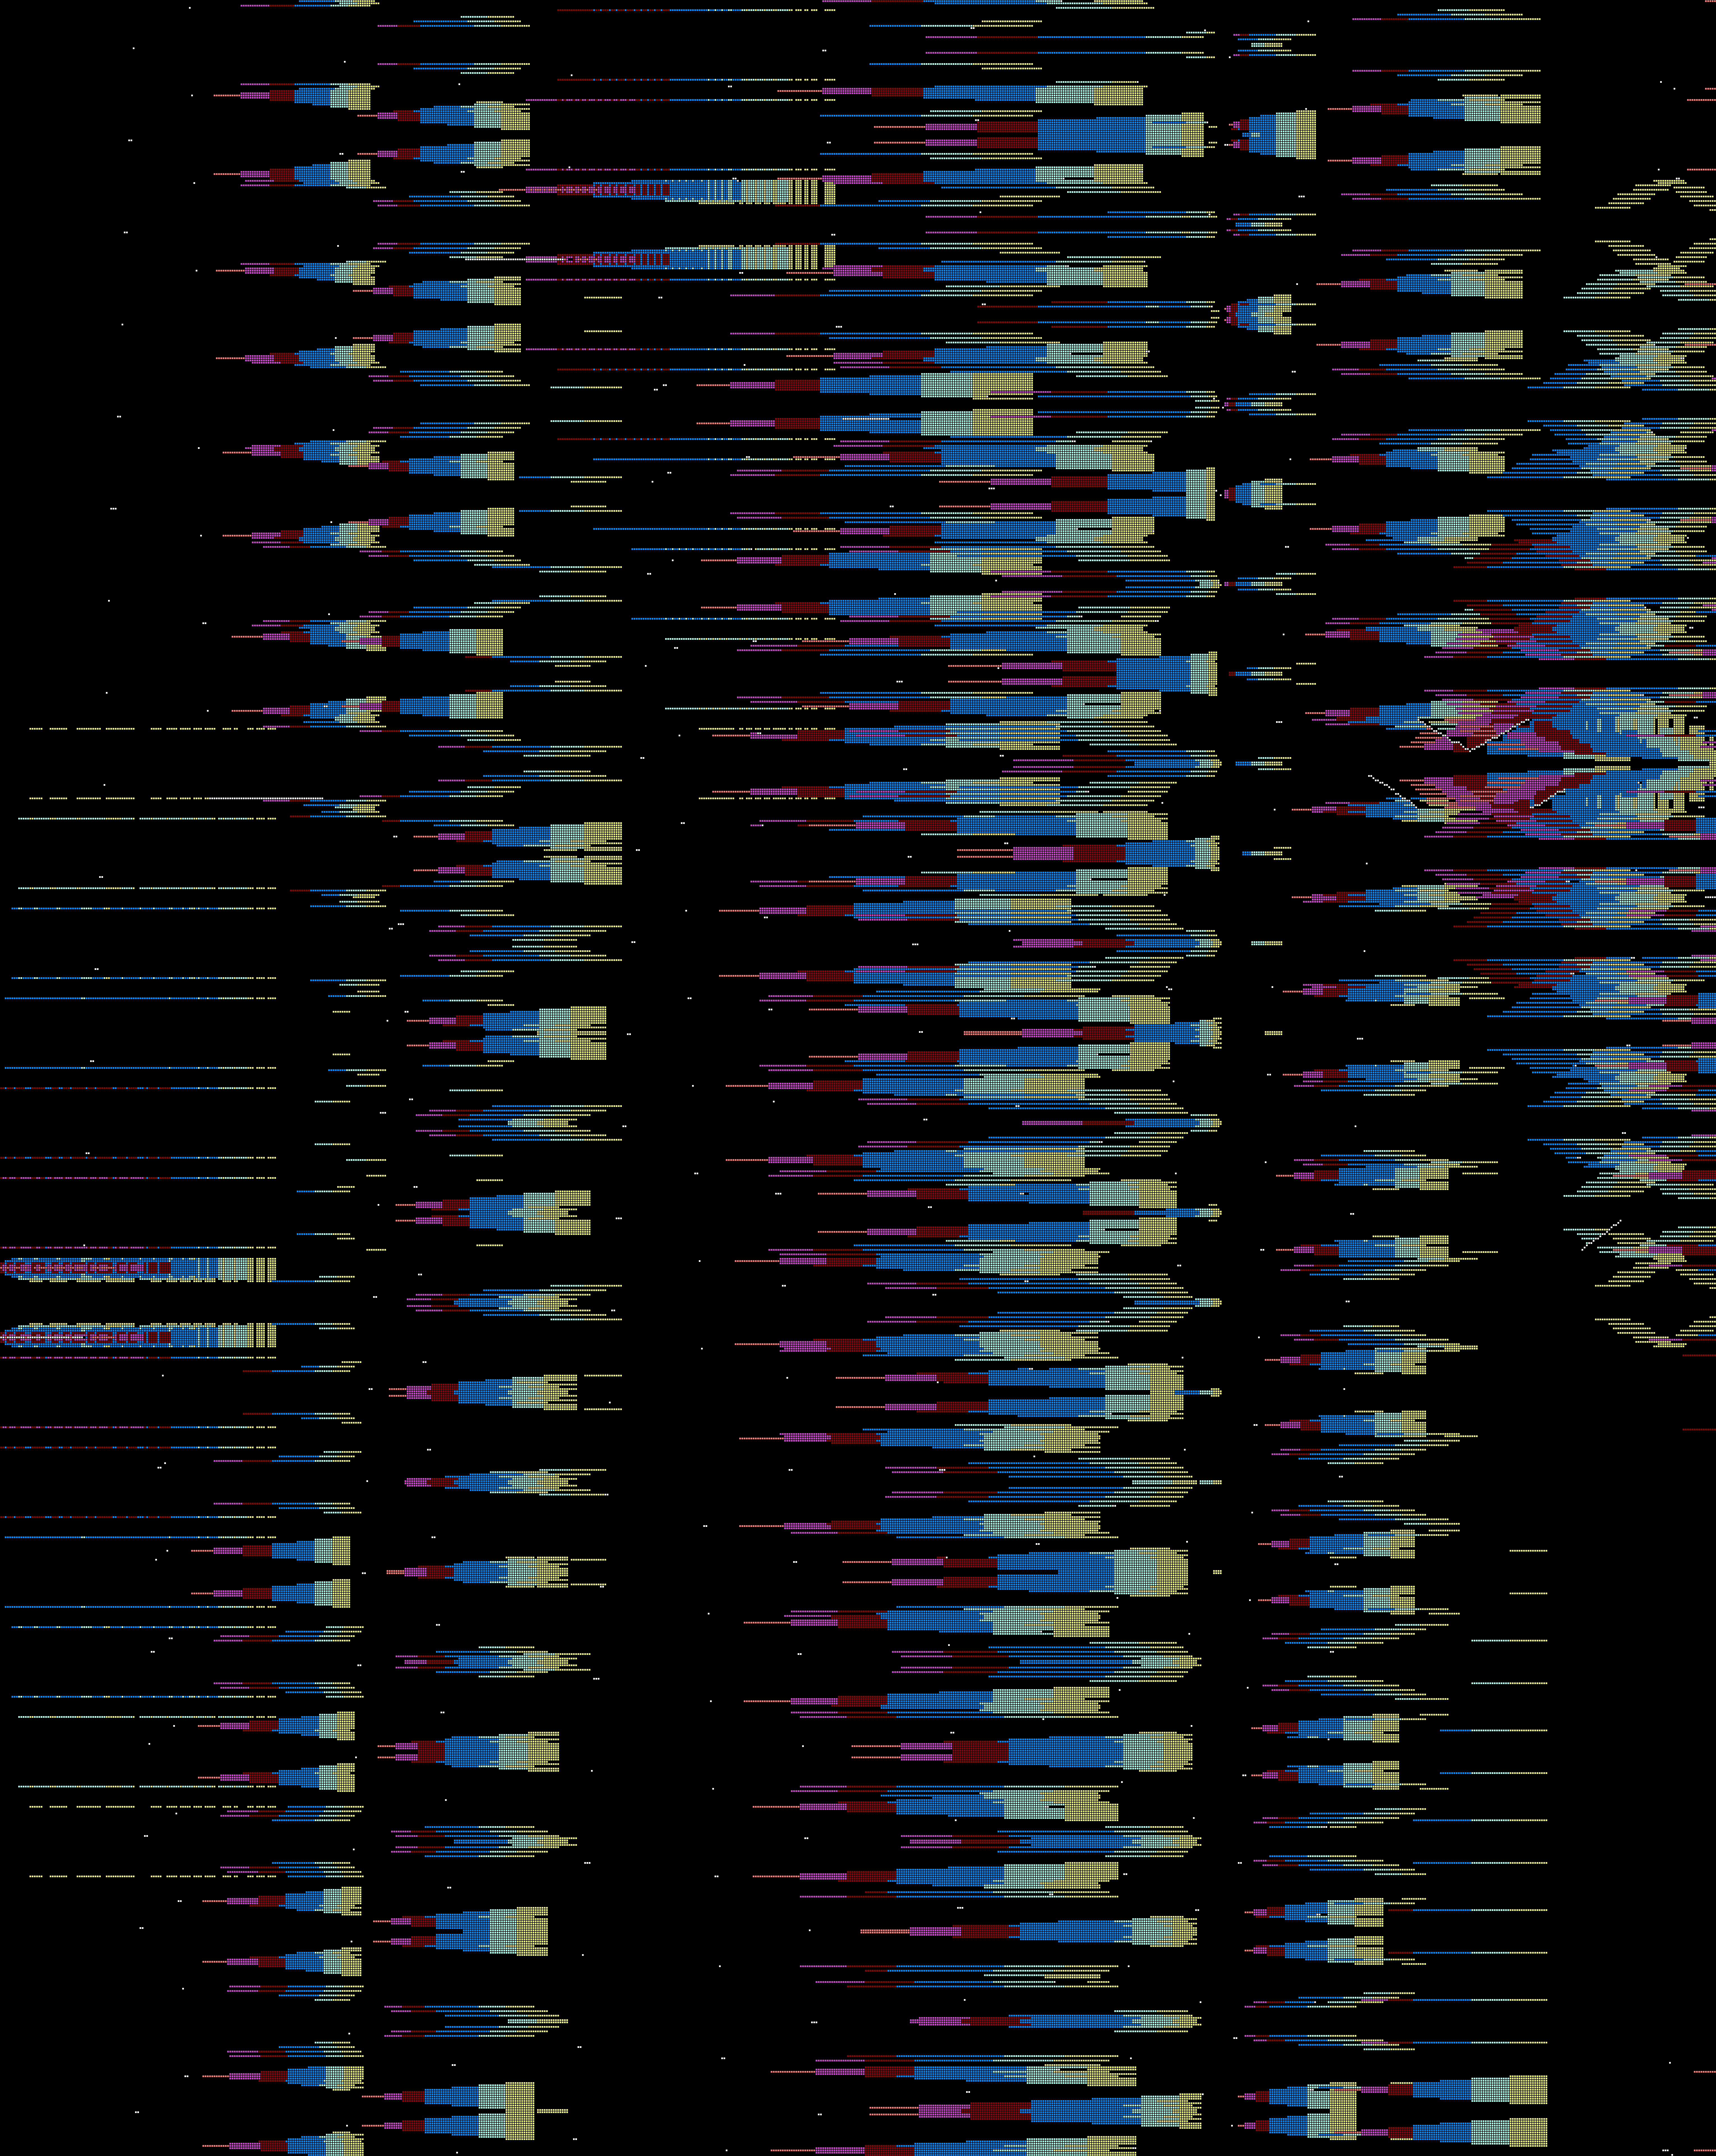

In [6]:
img